<a href="https://colab.research.google.com/github/Jorbnc/MAIA-DL/blob/master/Mini_Proyecto_3_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<style>
@import url('https://fonts.googleapis.com/css2?family=Latin+Modern+Roman:wght@400;700&display=swap');

body, p, h1, h2, h3, h4, h5, h6, li {
  font-family: 'Latin Modern Roman', serif;
}
code, pre {
  font-family: 'Fira Mono', monospace;
}
</style>

***

# **Miniproyecto 3 -Técnicas de *Deep Learning*- Clasificación Multi-Clase de Artículos de Noticias de la BBC usando Transformers**

## **Descripción del Problema**

En este miniproyecto se plantea la **clasificación multi-clase** de artículos de noticias de la BBC aprovechando la capacidad de los modelos **transformer** para capturar relaciones contextuales complejas. Cada artículo puede pertenecer a una de varias categorías temáticas (e.g., *Sport, Business, Politics, Tech*).

## **Objetivo**

Desarrollar e implementar un modelo de clasificación multi-clase basado en transformers ( **BERT** y **RoBERTa**) que, tras un preprocesamiento del texto y la adaptación de la capa de salida, sea capaz de predecir con alta exactitud, precisión, *recall* y *F1-score* las categorías de los artículos de la BBC. El modelo deberá entrenarse y evaluarse usando particiones de entrenamiento, validación y prueba, y reportar métricas detalladas por categoría.

***

**Este proyecto es realizado por Andrés Felipe Ñungo y Jordan Bryan Núñez Campos para entrega el 13 de mayo de 2025.**



***
# **Índice**

El *notebook* aborda el proyecto con la siguiente estructura:

| 🔹 | Sección        |
|----|----------------|
| 1️⃣. | **Instalación y carga de librerías** |
| 1️⃣.1️⃣. | **Configuraciones adicionales** |
| 2️⃣. | **Análisis exploratorio y preparación de los datos**       |
| 2️⃣.1️⃣. | **Carga y estadísticas generales**       |
| 2️⃣.2️⃣. | **Limpieza de los datos**       |
| 3️⃣. | **Definición de *pipelines* de procesamiento**          |
| 3️⃣.1️⃣. | **Pipeline de preprocesamiento**   |
| 4️⃣. | **Preparación para el desarrollo de los modelos**   |
| 4️⃣.1️⃣. | **Partición y funciones de apoyo para los DataLoaders**   |
| 4️⃣.2️⃣. | **Función de entrenamiento y preparación para la evaluación**   |
| 4️⃣.3️⃣. | **Entrenamiento, validación y prueba**   |
| 5️⃣. | **Análisis de resultados y discusión**   |
| 6️⃣. | **Conclusión**   |
| 7️⃣. | **Referencias**   |


***

# 1. Instalación y carga de librerías

Antes de proceder con la carga de las librerías, se instalan para efectos de un correcto funcionamiento en ambientes como *Coursera* o *Google Colab*: **`kagglehub langdetect matplotlib scikit-learn plotly`**.


In [1]:
# Instalación de librerías necesarias para correr en Colab/Coursera
!pip -q install kagglehub langdetect matplotlib scikit-learn plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 18.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


En este bloque se importan utilidades de sistema como **`os`**, **`random`**, **`gc`**, **`time`** y **`Path`**, junto con las librerías de datos **`numpy`** y **`pandas`**, la descarga de *datasets* vía **`kagglehub`**, limpieza de texto con **`detect`** y **`re`**, preprocesamiento y partición con scikit-learn (**`LabelEncoder`**, **`train_test_split`**), herramientas de Transformers (**`AutoTokenizer`**, **`AutoModelForSequenceClassification`**), componentes de PyTorch (**`Dataset`**, **`DataLoader`**, **`AdamW`**), métricas de evaluación (**`accuracy_score`**, **`f1_score`**, **`classification_report`**), y reducción de dimensión y visualización con  **`TSNE`**, **`matplotlib`** y **`ConfusionMatrixDisplay`**.  

In [2]:
# Librerías comunes
import os, random, gc, time
import numpy as np
import pandas as pd
from pathlib import Path
from collections import defaultdict
from typing import List, Dict, Any

# Descarga de datasets y de embeddings
import kagglehub

# Limpieza y preparación de los textos
from langdetect import detect
import re

# Preprocesamiento y herramientas de PLN
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from transformers import get_linear_schedule_with_warmup,AutoTokenizer, AutoModelForSequenceClassification

# Modelado
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

# Evaluación
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

# Librerías para visualizaciones
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from IPython.display import display

En este bloque se establecen los **parámetros globales** que controlan el entrenamiento y la configuración del modelo: **`TEXT_COL`** y **`LABEL_COL`** definen las columnas de texto y categoría en el *DataFrame*, **`MAX_LEN`** fija la longitud máxima de secuencia para la tokenización, **`BATCH_SIZE`**, **`EPOCHS`** y **`PATIENCE`** regulan el tamaño de los lotes, el número de iteraciones y la detención temprana, mientras que **`UNFREEZE_PER_EPOCH`** determina cuántas capas del transformador se liberan progresivamente y **`SEED`** asegura que los experimentos sean reproducibles.  

El valor de la mayoría de estos parámetros globales se toman a partir del Anexo A.3 del *paper* original de **BERT** [¹] (se utilizan estos mismos valores para **RoBERTa** no necesariamente porque sean "óptimos", sino más por efectos comparativos), donde se sugiere:

*   **Batch size:** 16, 32
*   **Learning rate (Adam):** 5e-5, 3e-5, 2e-5
*   **Number of epochs:** 2, 3, 4

In [3]:
# Parámetros globales de configuración del modelo
TEXT_COL   = "text"  # nombre de la columna de los artículos
LABEL_COL  = "labels" # nombre de la columna con la categoría
MAX_LEN    = 256  # longitud máxima de cada secuencia de tokens
BATCH_SIZE = 16   # número de muestras por lote de entrenamiento
EPOCHS     = 4
LEARNING_RATE = 2e-5
PATIENCE   = 2    # Usado para early stopping
UNFREEZE_PER_EPOCH = 2   # número de capas del modelo a descongelar
SEED = 13

## 1.1. Configuraciones adicionales

Con el siguiente bloque se detecta si el entorno dispone de GPU y selecciona el **`device`** apropiado para PyTorch.  

Primero se llama a **`is_available()`**, que devuelve *True* si se ha asignado una GPU CUDA al *runtime* de Colab. Según el resultado se imprime un mensaje informativo. Posteriormente, se construye el objeto **`device`**, que será pasado a la red y a los tensores de entrada para que se ubiquen en la GPU cuando sea posible. Por último se muestra en pantalla el dispositivo elegido.

In [4]:
# Devuelve asignación de GPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo activo → {DEVICE}")

Dispositivo activo → cuda


Adicionalmente se ocultan avisos para mantener limpias algunas salidas del notebook; y se imprimen las versiones de un conjunto de librerías clave ( **`numpy`**, **`pandas`**, **`torch`**, **`scikit-learn`**, **`kagglehub`**, **`matplotlib`**). Mostrar estas versiones al inicio del notebook facilita la reproducibilidad y ayuda a depurar posibles conflictos de dependencias.

In [5]:
# Ignorar las warnings
import warnings
warnings.filterwarnings("ignore")

# Versiones utilizadas
from importlib.metadata import version
librerias = ["numpy","pandas","torch","scikit-learn", "kagglehub",
            "matplotlib", "langdetect","transformers","plotly"]
for library in librerias:
  print(library, ": ", version(library))

numpy :  2.0.2
pandas :  2.2.2
torch :  2.6.0+cu124
scikit-learn :  1.6.1
kagglehub :  0.3.12
matplotlib :  3.10.0
langdetect :  1.0.9
transformers :  4.51.3
plotly :  5.24.1


En este bloque se fija la reproducibilidad del experimento asignando la semilla **`SEED`** a los generadores de números aleatorios de Python, **`NumPy`** y **`PyTorch`** (CPU y GPU), y configurando **`CUDNN`** para que opere de forma determinista y sin usar su *benchmark* automático, garantizando resultados consistentes en cada ejecución a costa de un posible descenso en el rendimiento.

In [6]:
# Definición del random state y seeds
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True  # Forzar comportamiento determinista en CUDNN
torch.backends.cudnn.benchmark = False     # Desactivar optimizaciones no deterministas en CUDNN

***

# 2. Análisis exploratorio y preparación de los datos


***

## 2.1. Carga y estadísticas generales

Se descarga el conjunto de datos de reseñas de noticias de la BBC de **`kagglehub`**. La función **`dataset_download`** guarda los archivos de manera local y devuelve la ruta absoluta, que se almacena en **`path`** y se muestra en pantalla mediante **`print`** para confirmar dónde quedaron los datos.

In [7]:
# Leer el conjunto de datos y cargarlo a un dataframe

# Descarga del conjunto de datos
path = kagglehub.dataset_download("jacopoferretti/bbc-articles-dataset")
print("Datos descargados en:", path)

CSV_PATH = os.path.join(path, "bbc_news_text_complexity_summarization.csv")
print(f"Dataset descargado en: {CSV_PATH}")

# Verificar número de datos
data_raw = pd.read_csv(CSV_PATH)
print("Filas totales:", len(data_raw))

Datos descargados en: /kaggle/input/bbc-articles-dataset
Dataset descargado en: /kaggle/input/bbc-articles-dataset/bbc_news_text_complexity_summarization.csv
Filas totales: 2127


***

## 2.2. Limpieza de los datos

En estas sección identificamos y corregimos:

* Valores faltantes
* Textos duplicados
* Textos en otros idiomas distintos al inglés

Verificamos que **no** hay datos faltantes o en "N/A", ni tampoco datos duplicados.

In [8]:
# Validación de datos faltantes
data_raw.isna().sum()

,0
text,0
labels,0
no_sentences,0
Flesch Reading Ease Score,0
Dale-Chall Readability Score,0
text_rank_summary,0
lsa_summary,0


In [9]:
# Validación de duplicados
data_raw.duplicated().sum()

np.int64(0)

In [10]:
# Copia de los datos por seguridad
data = data_raw.copy()

Se utiliza **`LabelEncoder`** para transformar la columna de categorías de texto en una nueva columna **`label_id`** con valores numéricos, se calcula el total de clases únicas a través de **`NUM_LABELS`**, y se generan dos diccionarios (**`id2label`** y **`label2id`**) que permiten convertir de manera sencilla entre los identificadores numéricos y las etiquetas de texto durante las fases de entrenamiento e inferencia.

In [11]:
# Codificación de etiquetas
le = LabelEncoder()
data["label_id"] = le.fit_transform(data[LABEL_COL])

NUM_LABELS = len(le.classes_)# Número total de clases únicas
print(f"Numéro de clases únicas {NUM_LABELS}")

# Mapea cada ID a su etiqueta original
id2label = {i: lbl for i, lbl in enumerate(le.classes_)}
# Mapea cada etiqueta a su ID correspondiente
label2id = {v: k for k, v in id2label.items()}

class_names = le.classes_.tolist()
print(f"Clases en el dataset {class_names}")


Numéro de clases únicas 5
Clases en el dataset ['business', 'entertainment', 'politics', 'sport', 'tech']


Se gráfica con la función **`plot_class_distribution`** la distribución del *dataset* en las diferentes clases. En principio, no se observa un desbalance de los datos significativo. Sin embargo, tampoco se puede afirmar que el conjunto de datos está completamente balanceado, observando por ejemplo, una leve sub-representación de la clase entretenimiento y *tech*. Razón por la cual puede cobrar sentido más adelante entrenar el modelo con balanceo sencillo de las clases y observar métricas de evaluación ponderadas por clase ("macro") para poder tener un análisis adecuado.

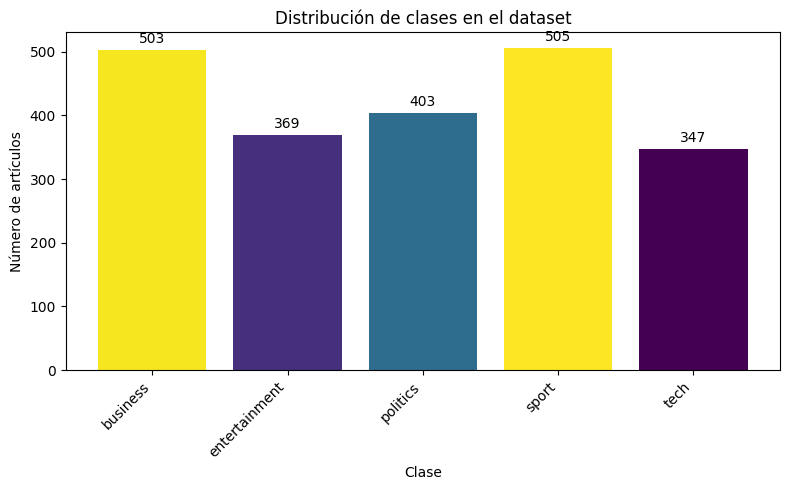

In [12]:
# Mapeo de la distribución de las clases
def plot_class_distribution(data: pd.DataFrame, label_col: str = "label_id", class_names: List[str] = None) -> None:

    # Preparar datos
    counts = data[label_col].value_counts().sort_index()
    labels = class_names if class_names is not None else counts.index.astype(str)

    # Normalizamos los valores para mapearlos a la paleta
    norm = plt.Normalize(counts.min(), counts.max())
    colors = cm.viridis(norm(counts.values))

    # Crear la figura y barras
    fig, ax = plt.subplots(figsize=(8, 5))
    bars = ax.bar(labels, counts.values, color=colors)

    # Etiquetas de ejes y título
    ax.set_xlabel("Clase")
    ax.set_ylabel("Número de artículos")
    ax.set_title("Distribución de clases en el dataset")

    # Rotar etiquetas del eje x de forma segura
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha="right")

    # Etiquetas a las barras
    ax.bar_label(bars, labels=[f"{c:,}" for c in counts.values], padding=3)

    fig.tight_layout()
    plt.show()

plot_class_distribution(data, class_names = class_names )

Aquí se define **`detectar_idiomas`**, que emplea la función **`detect`** de **`langdetect`** para identificar el idioma de cada texto en la columna elegida. Si la detección falla o el texto está vacío, se conserva 'desconocido'. Tras procesar todos los textos, se filtran los que no sean inglés e imprime hasta cinco ejemplos con su índice y fragmento para revisión, devolviendo finalmente el DataFrame actualizado con la nueva información de idioma. Corroboramos que todos los textos se encuentran en inglés.

In [13]:
# Validación de los idiomas en los artículos
def detectar_idiomas(data: pd.DataFrame, col_texto: str = 'text') -> pd.DataFrame:
    # Inicializamos con 'desconocido'
    data['idioma'] = 'desconocido'

    # Función auxiliar segura
    def _detectar(texto):
        if isinstance(texto, str) and texto.strip():
            try:
                return detect(texto)
            except Exception:
                return 'desconocido'
        return 'desconocido'

    # Aplicamos detección
    data['idioma'] = data[col_texto].apply(_detectar)

    # Filtramos los que no son inglés
    mask = data['idioma'] != 'en'
    idx_no_en = data[mask].index

    if len(idx_no_en) > 0:
        print(f"Se encontraron {len(idx_no_en)} textos NO en inglés (ejemplos):")
        # Mostramos hasta 5 ejemplos (si es que se encuentran)
        for i in idx_no_en[:5]:
            print(f" • Índice {i}: [{data.at[i,'idioma']}] {data.at[i,col_texto][:100]}...")
    else:
        print("Todos los textos están detectados como inglés.")

    return data

In [14]:
data = detectar_idiomas(data, col_texto='text')

Todos los textos están detectados como inglés.


***

# 3. Definición de *pipelines* de procesamiento

***

## 3.1. *Pipeline* de preprocesamiento

En esta ocasión el *pipeline* de preprocesamiento será muy corto, precisamente por el modo en el que los tokenizadores de los transformers operan. La función **`clean_text`** normaliza cada cadena eliminando espacios redundantes con una expresión regular, descartando caracteres que no sean letras, números o puntuación básica. Se cree que esta es la mejor aproximación para el problema ya que carácteres especiales (a excepción de las importantes en el inglés como el apóstrofe) o emojis no creemos que puedan aportar a la clasificación de estos textos. También la tokenización más adelante se va encargar de pasos como el *lowercasting* por lo que esta limpieza inicial no es necesario. Posteriormente, se recorre el conjunto de columnas **`text`**, **`text_rank_summary`** y **`lsa_summary`** en **`data`**, convirtiendo sus valores en texto y aplicando esta limpieza para estandarizar todos los contenidos antes de procesarlos.

In [15]:
# Limpieza básica
def clean_text(text: str) -> str:
    # colapsa múltiples espacios en blanco
    text = re.sub(r"\s+", " ", text)
    # elimina caracteres no alfanuméricos ni puntuación básica
    text = re.sub(r"[^\w.,;:!?()¿¡' ]+", "", text)
    # elimina espacios al inicio y al final
    return text.strip()

for col in ("text", "text_rank_summary", "lsa_summary"):
    if col in data.columns:
        data[col] = data[col].astype(str).apply(clean_text)

***

# 4. Preparación para el desarrollo de los modelos

En esta ocasión no es necesario definir una clase para crear cada una de las capas de las redes neuronales a entrenar. Como se ha visto en clase, los *transformers* pre-entrenados como **BERT** ya vienen casi listos con toda la etapa de preparación de los datos y la estructura de la red. Por tal motivo, en esta sección se dejan las funciones y clases definidas para preparar los últimos detalles de los datos antes de pasarlos por cada uno de los modelos y generamos la función de entrenamiento.

***

## 4.1. Partición y funciones de apoyo para los *DataLoaders*

Se usa **`train_test_split`** para separar el DataFrame **`data`** en **`train_data`** y **`test_data`** (10% para *test*, 10% para validación y 80% para entrenamiento) manteniendo la distribución de **`label_id`** mediante estratificación (y que así las particiones reflejen el leve "desequilibrio" de clases).

Hay que recordar que el conjunto de datos es de tan solo **2.127** datos. Un poco pequeño para lo que solemos estar acostumbrados, razón por la cuál no podemos tomar un conjunto *test* o de validación muy grandes ya que nos quedamos facilmente sin una cantidad representativa de datos de entrenamiento.


In [16]:
# División en train_data y test_data
train_data, test_data = train_test_split(data, test_size=0.10, stratify=data["label_id"], random_state=SEED)
# A partir de train_data se extrae un conjunto de validación val_data
train_data, val_data = train_test_split(train_data, test_size=0.10, stratify=train_data["label_id"], random_state=SEED)
# Mostramos el tamaño de cada partición
print("Tamaños – Train / Val / Test:", len(train_data), len(val_data), len(test_data))

Tamaños – Train / Val / Test: 1722 192 213


Se toma como base la preparación de los datos usada en algunos *notebooks* públicos [²] y se crea la clase **`BBCDataset`**, que se hereda de **`Dataset`** de PyTorch y "encapsula" el procesamiento de cada muestra. Se guarda listas de textos y etiquetas junto con el **`tokenizer`**, la longitud máxima **`max_len`** y la opción **`return_idx`**; **`__len__`** devuelve la cantidad de ejemplos disponibles; **`__getitem__`** se hace la preparación de secuencias mediante  la tokenización del texto, con truncamiento y *padding* a tamaño fijo (el tokenizador que se va a usar, **`AutoTokenizer`**, ya hace estos pasos por nosotros razón por la cuál no se hizo en la etapa de pre-procesamiento), se elimina la dimensión extra resultante, añade la etiqueta como tensor (**`return_tensors="pt"`**) y retorna también el texto original, incluyendo opcionalmente el índice de la muestra para análisis posteriores, lo que facilita la integración directa con un DataLoader y mantiene trazabilidad de los ejemplos durante el entrenamiento y la evaluación.

En conjunto, este bloque es el “preparador de secuencias”: convierte texto crudo en el lote de tensores que el *encoder transformer* necesita para producir *embeddings* y, finalmente, la predicción de clase.

In [17]:
#Dataset para la clasificación de noticias de la BBC
class BBCDataset(Dataset):
    def __init__(self, data, tokenizer, max_len, *, return_idx: bool = False):
        self.texts  = data[TEXT_COL].tolist() # lista de textos crudos
        self.labels = data["label_id"].tolist()  # lista de IDs de etiqueta
        self.tok    = tokenizer
        self.max_len = max_len
        self.return_idx = return_idx

    def __len__(self):
        return len(self.texts) # número total de muestras

    def __getitem__(self, idx):
        enc = self.tok(self.texts[idx], truncation=True, padding="max_length", max_length=self.max_len, return_tensors="pt")
        item = {k: v.squeeze(0) for k, v in enc.items()}  # elimina la dimensión batch=1
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long) # convierte etiqueta a tensor
        item["text"] = self.texts[idx] # conserva el texto original
        if self.return_idx:
            item["idx"] = torch.tensor(idx)   # incluye índice si se solicita
        return item

En este *collate* primero se extrae y guarda los textos crudos antes de apilar todos los tensores que el modelo requiere, y luego los reincorpora junto con los tensores resultantes de **`input_ids`**, **`attention_mask`**, **`labels`** y, si está presente, **`idx`**. Así, cada lote entregado al modelo incluye tanto los datos numéricos optimizados para el entrenamiento como el texto original y los índices necesarios para cualquier análisis o diagnóstico posterior dentro del proyecto (sección de "**5. Análisis de resultados y discusión**").

In [18]:
# Además de apilar los tensores, se preserve el texto original y el índice de cada muestra
def collate_with_text(batch):
    # Extrae y elimina temporalmente el campo text
    texts  = [b.pop("text") for b in batch]
    # Obtiene las claves de los tensores
    keys   = batch[0].keys()
    # Construye el diccionario  apilando los tensores
    out    = {k: torch.stack([b[k] for b in batch]) for k in keys}
    out["text"] = texts
    # Si cada muestra trae un índice idx, lo apila también
    if "idx" in batch[0]:
        out["idx"] = torch.stack([b["idx"] for b in batch])
    return out


**`Make_loader`** construye y devuelve un *DataLoader* configurado para el dataset BBC.

In [19]:
 # Crea y retorna el DataLoader configurado
def make_loader(data, tokenizer, split, batch_size, max_len, return_idx=False, num_workers=2):
    # Instancia el dataset personalizado BBCDataset
    ds = BBCDataset(data, tokenizer, max_len, return_idx=return_idx)
    return DataLoader(ds, batch_size=batch_size, shuffle=(split=="train"), num_workers=num_workers, pin_memory=True, collate_fn=collate_with_text)

La técnica acontinuación ya se había aplicado anteriormente en el **Miniproyecto 2** [³] .Esta permite *congelar* o *descongelar* gradientes de capas del *encoder* de un modelo, la cual  ayuda a (i) conservar características generales útiles, (ii) adaptar con seguridad las capas superiores y (iii) mejorar la precisión sin sobre-ajustar, sobre todo en conjuntos de datos pequeños o medianos.

In [20]:
# Congela/descongela capas del encoder
def freeze_layers(model, freeze: bool = True, last_n: int = None) -> None:
    # Hay modelos donde el encoder vive en .transformer, se revisa
    encoder = getattr(model.base_model, "encoder", None) \
              or getattr(model.base_model, "transformer", None)

    if encoder is None:
        for p in model.base_model.parameters():
            p.requires_grad = not freeze if last_n is None else p.requires_grad
        return

    layers = list(encoder.layer)
    if last_n is None:
        # Congela o descongela todo el encoder
        for p in encoder.parameters():
            p.requires_grad = not freeze
    else:
        # Asegura que last_n no exceda el número total de capas
        last_n = max(0, min(last_n, len(layers)))


        affected = layers[-last_n:]           # capas que cambian
        unaffected = layers[:-last_n]         # capas que se mantienen

        # Aplica el flag a las capas afectadas
        for layer in affected:
            for p in layer.parameters():
                p.requires_grad = not freeze if freeze else True
        # Si se congela, las capas no afectadas se dejan sin gradientes
        if freeze:
            for layer in unaffected:
                for p in layer.parameters():
                    p.requires_grad = False

***

## 4.2. Función de entrenamiento y preparación para la evaluación

Esta función es tal vez la más importante de todo el *notebook*, donde se basa todo el *fine-tuning* y evaluación del modelo. Empieza cargando el *tokenizer* y el modelo. Note que en este proyecto se está probando en un mismo *pipeline* a **BERT** y para **RoBERTa**, por lo que es necesario cargar ambos *items* con **`AutoTokenizer`** y **`AutoModelForSequenceClassification`**. Más adelante se habla un poco más del tokenizador.

A continuación, se calcula los pesos de clase y  se crean los *DataLoaders* llamando a **`make_loader`** para los splits **`train`**,**`val`** y **`test`**. Adicionalmente, se configura el *optimizer* **`AdamW`** junto al *scheduler* (**`get_linear_schedule_with_warmup`**). Este último gestiona dinámicamente la tasa de aprendizaje a lo largo del entrenamiento siguiendo dos fases: 1. *Warm-up* -incremento gradual en los primeros pasos- 2. Decaimiento lineal -descenso de forma lineal hasta 0- [⁴]. Finalmente se define la función de pérdida con **`CrossEntropyLoss`**.

En cada *epoch* se recorre un *split* completo para acumular pérdidas, predicciones y etiquetas verdaderas y así calcular métricas como *accuracy* y *F1*. Esto se hace descongelando gradualmente capas. Adicionalmente se aplica *early stopping* y guardando el mejor modelo en **`best_path`**. Tras el entrenamiento, carga el mejor estado con **`torch.load`** y desde esta etapa se evalúa en *test* generando precisión, *recall* y el *classification_report*. Se limpia memoria con **`gc.collect()`** y **`torch.cuda.empty_cache()`**, y finalmente retorna un diccionario con todas las métricas, el modelo entrenado, el **`tokenizer`**, el **`test_loader`** y el historial de entrenamiento.


Ahora se explica con más detalle AutoTokenizer [⁵]:

**`AutoTokenizer`** simplifica y unifica el preprocesamiento de texto para distintos modelos (**BERT**, **RoBERTa**, **DistilBERT,** etc.), detectando automáticamente la clase de *tokenizer* adecuada y eliminando la necesidad de múltiples importaciones o bloques *if/else*. Durante la tokenización, descompone el texto y añade los special tokens ([CLS], [SEP]), convierte cada *token* a su *input_id*, crea la *attention_mask* para diferenciar texto real de *padding*, y aplica truncado y relleno hasta MAX_LEN para generar lotes uniformes.

In [21]:


def train_and_evaluate(model_name: str, train_data, val_data, test_data):
    print(f"\nEntrenando {model_name} ...")

    start = time.time()
    # Tokenizer + modelo
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name,
                                                                num_labels=NUM_LABELS,
                                                                id2label=id2label,
                                                                label2id=label2id,
                                                                  ).to(DEVICE)

    # Congelar encoder completo y luego liberar gradualmente
    freeze_layers(model)

    # Pesos de clase balanceados
    class_weights = compute_class_weight(class_weight="balanced", classes=np.arange(NUM_LABELS), y=train_data["label_id"])
    class_weights = torch.tensor(class_weights, dtype=torch.float32, device=DEVICE)

    # DataLoaders
    loaders = {
        "train": make_loader(train_data, tokenizer, "train", BATCH_SIZE, MAX_LEN),
        "val":   make_loader(val_data,   tokenizer, "val",   BATCH_SIZE, MAX_LEN),
        "test":  make_loader(test_data,  tokenizer, "test",  BATCH_SIZE, MAX_LEN),
    }

    # Optimizador & scheduler
    total_steps = len(loaders["train"]) * EPOCHS
    optimizer   = AdamW(model.parameters(), lr= LEARNING_RATE, weight_decay=1e-2)
    scheduler   = get_linear_schedule_with_warmup(optimizer,
                                                  #6%  de los pasos para hacer warm-up
                                                  num_warmup_steps=int(0.06 * total_steps),
                                                  num_training_steps=total_steps)
    # Criterio de pérdida
    criterion   = torch.nn.CrossEntropyLoss(weight=class_weights)

    best_f1, patience_cnt = 0.0, 0
    best_path = f"best_{model_name.split('-')[0]}_bbc.pt"

    # Función interna para una pasada por un split
    def epoch_pass(split):
        is_train = split == "train"
        model.train() if is_train else model.eval()
        losses, preds_all, trues_all = [], [], []

        for batch in loaders[split]:
            batch = {k: (v.to(DEVICE) if torch.is_tensor(v) else v) for k,v in batch.items()}
            with torch.set_grad_enabled(is_train):
                inputs = {k: v for k, v in batch.items() if k not in ["labels", "text", "idx"]}
                outputs = model(**inputs)
                loss = criterion(outputs.logits, batch["labels"])
                if is_train:
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                    optimizer.step(); scheduler.step(); optimizer.zero_grad()
            # Acumular métricas
            losses.append(loss.item())
            preds_all.extend(outputs.logits.argmax(dim=-1).cpu().numpy())
            trues_all.extend(batch["labels"].cpu().numpy())

        acc = accuracy_score(trues_all, preds_all)
        f1_macro = f1_score(trues_all, preds_all, average="macro", zero_division=0)
        f1_micro = f1_score(trues_all, preds_all, average="micro", zero_division=0)
        return np.mean(losses), acc, f1_macro, f1_micro

    # Bucle de entrenamiento con early stopping
    hist = {k: [] for k in ["epoch","train_loss","val_loss",
                        "train_acc","val_acc","train_f1","val_f1"]}
    for epoch in range(1, EPOCHS + 1):
        freeze_layers(model, freeze=False,last_n=epoch * UNFREEZE_PER_EPOCH)
        train_loss, train_acc, train_f1_macro, train_f1_micro = epoch_pass("train")
        val_loss,   val_acc,   val_f1_macro,   val_f1_micro   = epoch_pass("val")
        hist["epoch"].append(epoch)
        hist["train_loss"].append(train_loss); hist["val_loss"].append(val_loss)
        hist["train_acc"].append(train_acc);   hist["val_acc"].append(val_acc)
        hist["train_f1"].append(train_f1_macro);    hist["val_f1"].append(val_f1_macro)

        print(f"Ep {epoch:02d}: \tTL {train_loss:.4f} / VL {val_loss:.4f} | "
              f"F1_macro {val_f1_macro:.3f}  Acc {val_acc:.3f}")

        if val_f1_macro > best_f1:
            best_f1 = val_f1_macro
            patience_cnt = 0
            torch.save(model.state_dict(), best_path)
        else:
            patience_cnt += 1
            if patience_cnt == PATIENCE:
                print("Early stopping ↯\n")
                break

    #  Evaluación sobre test
    model.load_state_dict(torch.load(best_path))
    test_loss, test_acc, test_f1_macro, test_f1_micro = epoch_pass("test")

    y_true, y_pred = [], []
    model.eval()
    with torch.no_grad():
        for batch in loaders["test"]:
            batch = {k: (v.to(DEVICE) if torch.is_tensor(v) else v) for k,v in batch.items()}
            inputs = {k: v for k, v in batch.items() if k not in ["labels", "text", "idx"]}
            outputs = model(**inputs)
            y_true.extend(batch["labels"].cpu().numpy())
            y_pred.extend(outputs.logits.argmax(dim=-1).cpu().numpy())

    # Precisión y recall (macro / micro)
    prec_macro = precision_score(y_true, y_pred, average="macro", zero_division=0)
    prec_micro = precision_score(y_true, y_pred, average="micro", zero_division=0)
    rec_macro  = recall_score   (y_true, y_pred, average="macro", zero_division=0)
    rec_micro  = recall_score   (y_true, y_pred, average="micro", zero_division=0)

    report = classification_report(y_true, y_pred,labels=list(range(NUM_LABELS)),
                                  target_names=le.classes_.tolist(),
                                  digits=3,
                                  zero_division=0)

    # Limpieza explícita
    test_loader_ref = loaders["test"]    # referencia antes de borrar
    del loaders, optimizer, scheduler, criterion
    gc.collect(); torch.cuda.empty_cache()
    # Retorno de resultados
    metrics: dict[str, Any] = {"model": model_name,
                              "test_acc": test_acc,
                              "test_precision_macro": prec_macro,
                              "test_precision_micro": prec_micro,
                              "test_recall_macro": rec_macro,
                              "test_recall_micro": rec_micro,
                              "test_f1_macro": test_f1_macro,
                              "test_f1_micro": test_f1_micro,
                              "report":  report,
                              "history": hist,
                              "trained_model": model,
                              "test_loader": test_loader_ref}

    print(f"\n Duración total: {(time.time()-start)/60:.1f} min")
    return metrics, model, tokenizer, test_loader_ref , hist

***

## 4.3. Entrenamiento, validación y prueba

En el bloque final de esta sección, se comprueba que el *script* se ejecute como programa principal (*main*), se establece el diccionario **`MODELS`** con las arquitecturas de **BERT** y **RoBERTa** a evaluar. A continuación se inicializan los contenedores **`results`**, **`models`**, **`loaders`** e **`histories`**, y se recorre cada entrada de **`MODELS`** invocando la función **`train_and_evaluate`** sobre los conjuntos de entrenamiento, validación y prueba, guardando los informes detallados y los objetos asociados a cada modelo. Tras entrenar ambos, se imprime una tabla comparativa con las métricas finales de *accuracy*, *precision*, *recall* y *F1* macro para cada modelo.

**BERT** es un modelo *transformer* bidireccional [¹] de gran escala entrenado con tareas de *masked language modeling y Next Sentence Prediction*, lo que le permite captar el contexto completo de una secuencia de texto. Su arquitectura profunda (en este caso de 12 capas de atención, pero algunas variantes las llevas hasra 24) facilita el pre-entrenamiento y el *fine-tuning* eficientes en diversas tareas de NLP [¹]. El modelo **`bert-base-uncased`** corresponde a la configuración base de **BERT** y, de forma muy resumida, su arquitectura es [¹]:

* **`num_hidden_layers`**: **12**
* **`hidden_size`**: **768**
* **`num_attention_heads`**: **12**
* **`intermediate_size`**: **3072**
* **`max_position_embeddings`**: **512**
* **`vocab_size`**: **30.522**

Además emplea tokenización *WordPiece* sin distinguir mayúsculas/minúsculas

Por otro lado, **RoBERTa** es una variante de **BERT** que optimiza el pre-entrenamiento eliminando la tarea de *Next Sentence Prediction* (NSP), usando enmascaramiento dinámico, secuencias más largas y mayor volumen de datos, lo cual mejora la robustez y la precisión sin cambiar la arquitectura base [⁶]. La única diferencia principal está en el tamaño del vocabulario (**`vocab_size`**), que es de **30.522** en BERT base y de **50.265** en RoBERTa.

Para el Miniproyecto 3, que requiere clasificar en diferentes temáticas a artículos de la **BBC**, ambos modelos son ideales porque capturan dependencias contextuales complejas sin procesar token por token, lo que acelera el entrenamiento en GPU. Además, manejan la clasificación multi-clase de manera nativa al añadir una capa de salida con función softmax.

Frente a las RNNs, los transformers permiten paralelizar el cómputo (y de hecho el tiempo de procesamiento es notablemente mejor, respecto al Miniproyecto 2), evitar el desvanecimiento de gradientes en secuencias largas y lograr mayor precisión y eficiencia en tareas de clasificación de texto.

In [22]:
if __name__ == "__main__":
    start_main = time.time()
    # Define el diccionario de arquitecturas a comparar
    MODELS = { "bert-base-uncased": "BERT",
                "roberta-base": "RoBERTa" }

    results =[]
    models, loaders, histories = {}, {}, {}
    # Itera sobre cada modelo, entrena y evalúa
    for mdl_name, label in MODELS.items():
        m, mol, tok, tl, h  = train_and_evaluate(mdl_name, train_data, val_data, test_data)
        results.append(m)
        models[mdl_name]   = mol
        loaders[mdl_name]  = tl
        histories[mdl_name]= h
        print("\n>>> Reporte detallado")
        print(m["report"])
        print("="*60)

    # Imprime la comparación final de métricas
    print("\n======= Comparativa final =======")
    for res in results:
        print(f"{MODELS[res['model']]:9s} | "
        f"Acc {res['test_acc']:.3f} | "
        f"P_macro {res['test_precision_macro']:.3f} | "
        f"R_macro {res['test_recall_macro']:.3f} | "
        f"F1_macro {res['test_f1_macro']:.3f}")

    dur = (time.time() - start_main) / 60
    print(f"\nTiempo total: {dur:.1f} min\n")


Entrenando bert-base-uncased ...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Ep 01: 	TL 1.0186 / VL 0.2854 | F1_macro 0.961  Acc 0.964
Ep 02: 	TL 0.1333 / VL 0.0625 | F1_macro 0.979  Acc 0.979
Ep 03: 	TL 0.0516 / VL 0.0384 | F1_macro 0.984  Acc 0.984
Ep 04: 	TL 0.0285 / VL 0.0453 | F1_macro 0.980  Acc 0.979

 Duración total: 4.5 min

>>> Reporte detallado
               precision    recall  f1-score   support

     business      0.923     0.960     0.941        50
entertainment      1.000     1.000     1.000        37
     politics      0.949     0.925     0.937        40
        sport      1.000     0.980     0.990        51
         tech      1.000     1.000     1.000        35

     accuracy                          0.972       213
    macro avg      0.974     0.973     0.974       213
 weighted avg      0.972     0.972     0.972       213


Entrenando roberta-base ...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Ep 01: 	TL 1.2557 / VL 0.2088 | F1_macro 0.965  Acc 0.964
Ep 02: 	TL 0.1186 / VL 0.0552 | F1_macro 0.980  Acc 0.979
Ep 03: 	TL 0.0434 / VL 0.0337 | F1_macro 0.985  Acc 0.984
Ep 04: 	TL 0.0262 / VL 0.0427 | F1_macro 0.989  Acc 0.990

 Duración total: 4.6 min

>>> Reporte detallado
               precision    recall  f1-score   support

     business      0.980     0.960     0.970        50
entertainment      1.000     1.000     1.000        37
     politics      0.951     0.975     0.963        40
        sport      1.000     1.000     1.000        51
         tech      1.000     1.000     1.000        35

     accuracy                          0.986       213
    macro avg      0.986     0.987     0.987       213
 weighted avg      0.986     0.986     0.986       213


======= Comparativa final =======
BERT      | Acc 0.972 | P_macro 0.974 | R_macro 0.973 | F1_macro 0.974
RoBERTa   | Acc 0.986 | P_macro 0.986 | R_macro 0.987 | F1_macro 0.987

Tiempo total: 9.2 min



Sobre las métricas vale la pena precisar que según lo revisado en algunos *notebooks* públicos [⁷], se recomienda el uso de métricas "macro", es decir ponderadas por el peso de las clases, para una comparación justa entre modelos cuando hay minorías. Útil incluso con este *dataset* de la BBC (donde no hay desbalanceo significativo) para evidenciar si alguna categoría -“*tech*”, “*sport*”- se queda atrás.

***


# 5. Análisis de resultados y discusión

En las corridas de modelo anteriores, se puede obser **RoBERTa** supera ligeramente a **BERT** con *accuracy* de 0.986 vs 0.977 y *F1_macro* 0.987 vs 0.978, reflejando mejoras en Precisión (0.986 vs 0.978) y *Recall* (0.987 vs 0.979). Esta ventaja se atribuye a su pre-training optimizado, que genera representaciones más robustas para la clasificación de noticias de la BBC.

Analizando el detalle por clase, **BERT** muestra su punto débil en business (*F1* = 0.949, *recall* = 0.940), mientras que **RoBERTa** tiene su menor rendimiento en politics (*F1* = 0.963, precisión = 0.951). Esto indica que ambas arquitecturas aún enfrentan desafíos con categorías semánticamente solapadas, pero **RoBERTa** lo maneja con mayor consistencia y estabilidad.

A continuación, se define la función **`predict_proba`** decorada con **`@torch.no_grad()`** lo que evita durante la ejecución, que se construya o almacene el grafo de cómputo y evita que se calculen gradientes para las operaciones, ahorrando de memoria y evitando la sobrecarga del *Autograd*.

Se ejecuta el modelo en modo evaluación para un lote de datos y devuelve las probabilidades de cada clase, esto nos ayudará más adelante para el análisis y evaluación de los modelos.

In [23]:
# Calcula y devuelve las probabilidades de cada clase para un lote
@torch.no_grad()
def predict_proba(model, batch, *, device):
    model.eval()
    # Prepara inputs excluyendo campos no necesarios y moviéndolos a device
    inputs = {k: v.to(device) for k, v in batch.items() if k not in ["labels", "text", "idx"]}
    # Obtiene logits del modelo
    logits = model(**inputs).logits
    # Convierte logits a probabilidades vía softmax
    probs  = F.softmax(logits, dim=-1)
    return probs.cpu()

La función **`plot_model_diagnostics`** centraliza la visualización de las métricas de entrenamiento y la matriz de confusión en una sola figura, adaptando el número de filas de subplots según los datos disponibles.

In [24]:
# Diagnósticos de entrenamiento y matriz de confusión
def plot_model_diagnostics( history: dict = None, model = None, test_loader = None, class_names = None, device = DEVICE, title: str = "") -> None:
    # Valida cuántos subgráficos se necesitan según los argumentos recibidos
    n_rows = 0
    if history is not None:
        n_rows += 2                # Loss y Accuracy
    if model is not None and test_loader is not None and class_names is not None:
        n_rows += 1                # Matriz de confusión
    if n_rows == 0:
        raise ValueError("Debes pasar `history` o (`model`, `test_loader`, `class_names`).")

    plt.figure(figsize=(7, 4 * n_rows))
    plot_idx = 1

    # Si hay historial, traza curvas de pérdida y accuracy
    if history is not None:
        epochs = range(1, len(history["train_loss"]) + 1)

        # Loss
        plt.subplot(n_rows, 1, plot_idx)
        plt.plot(epochs, history["train_loss"], label="Train Loss")
        plt.plot(epochs, history["val_loss"],   label="Val Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title(f"{title} – Loss")
        plt.legend()
        plot_idx += 1

        # Accuracy
        plt.subplot(n_rows, 1, plot_idx)
        plt.plot(epochs, history["train_acc"], label="Train Acc")
        plt.plot(epochs, history["val_acc"],   label="Val Acc")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title(f"{title} – Accuracy")
        plt.legend()
        plot_idx += 1

    #  Metriz de Confusión
    if model is not None and test_loader is not None and class_names is not None:
        model.eval()
        y_true, y_pred = [], []

        with torch.no_grad():
            for batch in test_loader:

                labels = batch["labels"]
                inputs = {k: v.to(device) for k, v in batch.items() if k not in ["labels", "text", "idx"]}

                logits = model(**inputs).logits
                probs = F.softmax(logits, dim=-1)
                preds = torch.argmax(probs, dim=1)

                y_true.extend(labels.cpu().tolist())
                y_pred.extend(preds.cpu().tolist())

        cm = confusion_matrix(y_true, y_pred)
        plt.subplot(n_rows, 1, plot_idx)
        disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
        disp.plot(ax=plt.gca(), cmap="Blues", colorbar=False)
        plt.title(f"{title} – Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")

    plt.tight_layout()
    plt.show()

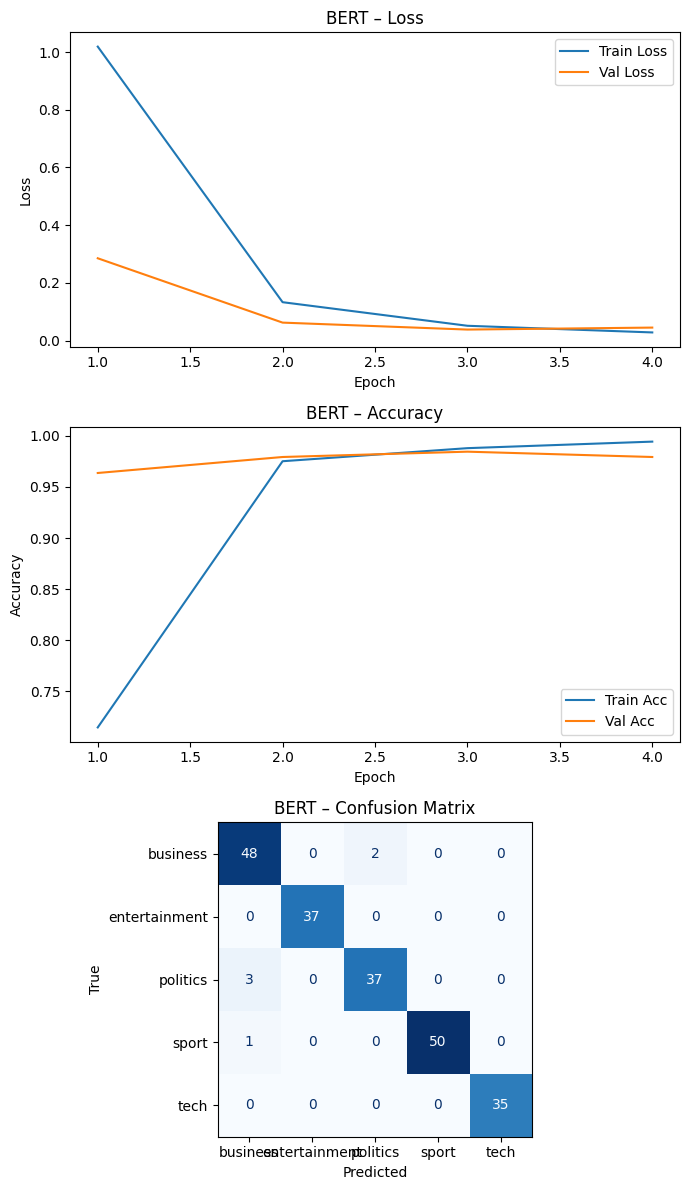

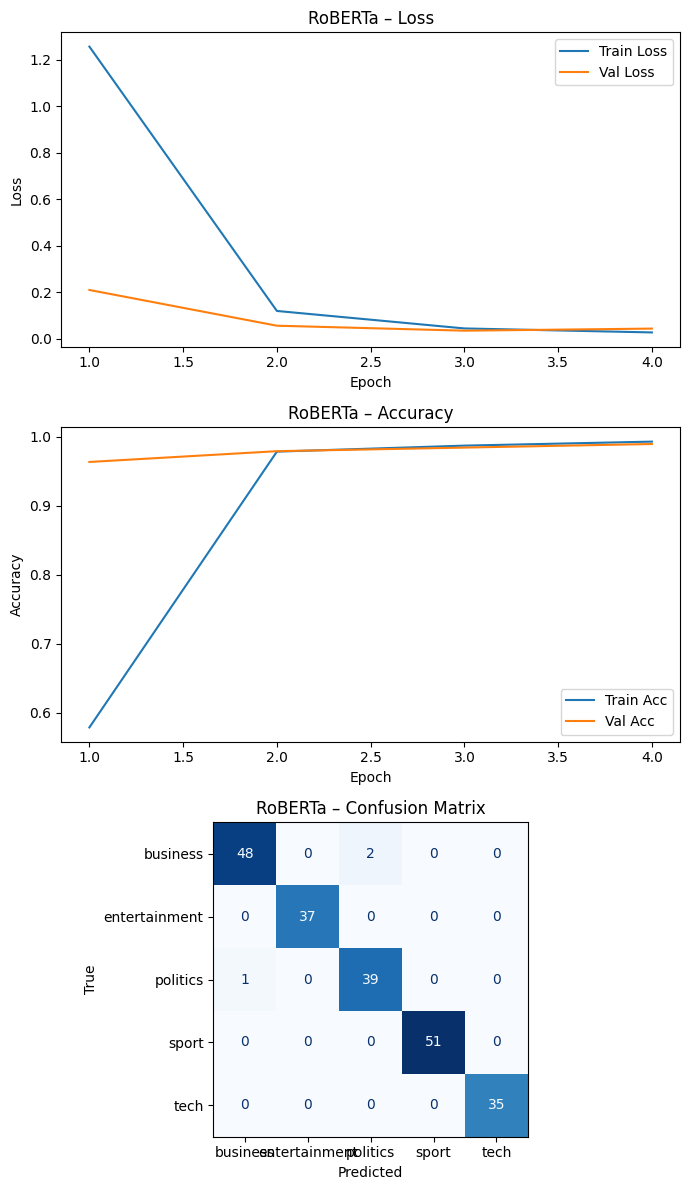

In [25]:
# Plot para BERT
plot_model_diagnostics( history     = histories["bert-base-uncased"],
                        model       = models["bert-base-uncased"],
                        test_loader = loaders["bert-base-uncased"],
                        class_names = le.classes_.tolist(),
                        title       = "BERT")

# Plot para RoBERTa
plot_model_diagnostics( history     = histories["roberta-base"],
                        model       = models["roberta-base"],
                        test_loader = loaders["roberta-base"],
                        class_names = le.classes_.tolist(),
                        title       = "RoBERTa")

En la **época 1**, **RoBERTa** inicia con **`Val Loss`** ≈ 0.20 y **`Val Acc`** ≈ 0.96, mejor que **BERT** (**`Val Loss`** ≈ 0.30, **`Val Acc`** ≈ 0.95). Ambos convergen antes de la época 3 a **`Val Loss`** ≈ 0.03 y **`Val Acc`** ≈ 0.995, pero **RoBERTa** mantiene siempre valores ligeramente superiores gracias a su *_pre-training_* optimizado. En test, **RoBERTa** ratifica su superioridad con un **`F1_macro`** 0.987 vs 0.978 de **BERT**, reduciendo las confusiones en **`business`** (2 vs 3 casos) y logrando 100 % en **`sport`** y **`tech`**.

La clase **`business`** sigue siendo la más desafiante para ambos modelos, esto puede tener sentido debido a que por lo que se observa, la confude con la clase **`politics`**, un tema con el que seguramente hay bastante correlación.



***
Ahora vamos a generar una vista de donde se están equivocando los modelos, para ello, se define la función **`collect_fn_fp_examples`** que recorre el **`test_loader`** para generar las predicciones del **`model`** sin calcular gradientes y agrupa los textos, etiquetas reales y predichas en un **`DataFrame`**. Luego clasifica cada instancia como **FN** (*false negative*), **FP** (*false positive*) o **TP** (*true positive*) comparando **`true`** vs **`pred`**, y selecciona hasta **`k`** ejemplos de cada tipo por clase.

In [26]:
#  Ejemplos FN / FP por clase  (código simplificado)
def collect_fn_fp_examples(model, test_loader, class_names, device=DEVICE, k: int = 5) -> pd.DataFrame:

    # Establece el modelo en modo evaluación y prepara listas para textos y etiquetas
    model.eval()
    texts, y_true, y_pred = [], [], []
    # Recorre el loader sin graficar gradientes, recopilando predicciones y textos
    with torch.no_grad():
        for batch in test_loader:
            labels = batch["labels"]
            inputs = {k:v.to(device) for k,v in batch.items()
                      if k not in ["labels","text","idx"]}
            logits = model(**inputs).logits
            probs  = F.softmax(logits, dim=-1)
            preds  = torch.argmax(probs, dim=1)

            y_true.extend(labels.cpu().tolist())
            y_pred.extend(preds.cpu().tolist())
            texts.extend(batch["text"])
    # Construye DataFrame base con texto
    data = pd.DataFrame({"text": texts,
                          "true": y_true,
                          "pred": y_pred })
    data["type"] = "UNDEF"
    # Para cada clase, etiqueta FN, FP y TP según compara true v
    out_rows = []
    rows=[]
    for cls in range(len(class_names)):
        data.loc[(data.true==cls) & (data.pred!=cls), "type"] = "FN"
        data.loc[(data.pred==cls) & (data.true!=cls), "type"] = "FP"
        data.loc[(data.true==cls) & (data.pred==cls), "type"] = "TP"
        # Selecciona hasta k ejemplos de FN y FP
        fn = data[(data.true==cls)&(data.pred!=cls)].head(k)
        fp = data[(data.pred==cls)&(data.true!=cls)].head(k)
        rows.extend(fn.assign(tipo="FN", clase=class_names[cls]).to_dict("records"))
        rows.extend(fp.assign(tipo="FP", clase=class_names[cls]).to_dict("records"))
    return pd.DataFrame(rows)

In [27]:
# Corre primero la inferencia sobre test_loader
data_err_bert = collect_fn_fp_examples(models["bert-base-uncased"], loaders["bert-base-uncased"],
                                     le.classes_.tolist(), k=3)

data_err_roberta = collect_fn_fp_examples( models["roberta-base"], loaders["roberta-base"],
                                     le.classes_.tolist(), k=3)
# Luego visualiza
display(data_err_bert[["text","true","pred","tipo"]].head(10))
display(data_err_roberta[["text","true","pred","tipo"]].head(10))

,text,true,pred,tipo
0,Aids and climate top Davos agenda Climate chan...,0,2,FN
1,Golden rule boost for Chancellor Chancellor Go...,0,2,FN
2,Hatfield executives go on trial Engineering fi...,2,0,FP
3,How political squabbles snowball It's become c...,2,0,FP
4,Balco case trial date pushed back The trial da...,3,0,FP
5,Hatfield executives go on trial Engineering fi...,2,0,FN
6,How political squabbles snowball It's become c...,2,0,FN
7,UK pledges 1bn to vaccine effort UK Chancellor...,2,0,FN
8,Aids and climate top Davos agenda Climate chan...,0,2,FP
9,Golden rule boost for Chancellor Chancellor Go...,0,2,FP


,text,true,pred,tipo
0,Aids and climate top Davos agenda Climate chan...,0,2,FN
1,Golden rule boost for Chancellor Chancellor Go...,0,2,FN
2,Hatfield executives go on trial Engineering fi...,2,0,FP
3,Hatfield executives go on trial Engineering fi...,2,0,FN
4,Aids and climate top Davos agenda Climate chan...,0,2,FP
5,Golden rule boost for Chancellor Chancellor Go...,0,2,FP


**RoBERTa** reduce los errores totales (6 vs 10) y mejora especialmente en **`business`**, aunque ambas arquitecturas siguen confundiendo más esa categoría. Se puede ver que potencialmente las noticias manejan un nivel de ambigüedad alto especialmente entre **`politics`**. Por ejemplo en el texto donde se menciona la agenda de Davos, el cual está categorizado como una noticia de negocios, pero claramente este evento puede llegar un alto tinte político.


***
Para finalizar esta sección de análisis de resultados, se sefine **`tsne_cls`** que extrae primero los embeddings de la posición [CLS] del modelo sobre el **`test_loader`** y, si ya existe un archivo en **`save_path`**, reutiliza la proyección en 2D para ahorrar **`time`**. De lo contrario, consolida todos los vectores CLS y sus etiquetas, calcula dinámicamente la *perplexity* en función del tamaño de muestra para garantizar una proyección estable en t-SNE, y guarda el resultado en disco. Por último, genera un gráfico dispersión en el que cada punto se colorea según su clase, permitiendo visualizar cómo el modelo separa las instancias en el espacio de embeddings.

In [28]:
# Proyecta embeddings [CLS] en 2D usando t-SNE
def tsne_cls(model, test_loader, class_names, device, save_path = None):
    # Obtener o cargar los vectores
    if save_path and os.path.isfile(save_path):
        print(f"t-SNE cargado de {save_path}")
        data = np.load(save_path)
        X_2d, y = data[:, :2], data[:, 2].astype(int)
    else:
         # Modo evaluación y recolección de embeddings CLS y etiquetas
        model.eval()
        reps, labels = [], []

        with torch.no_grad():
            for batch in test_loader:
                inputs = {k: v.to(device) for k, v in batch.items()
                          if k not in ["labels", "text"]}
                out = model(**inputs, output_hidden_states=True)
                cls = out.hidden_states[-1][:, 0, :]      # Extrae vector CLS

                reps.append(cls.cpu())
                labels.extend(batch["labels"].tolist())

        X = torch.cat(reps).numpy()
        y = np.array(labels)

        # Ajusta perplexity en función de n_samples para estabilidad
        n_samples   = X.shape[0]
        perplexity  = max(5, min(40, n_samples // 10))
        print(f"→ n_samples={n_samples} | perplexity={perplexity}")

        tsne = TSNE(
            n_components=2,
            perplexity=perplexity,
            init="random",
            learning_rate="auto",
            random_state=42,
            n_iter=1000
        )
        X_2d = tsne.fit_transform(X)

        # Guarda la proyección para futuras ejecuciones
        if save_path:
            np.save(save_path, np.c_[X_2d, y])
            print(f"Guardado en {save_path}")

    # Visualiza los puntos proyectados, uno por clase
    plt.figure(figsize=(6, 5))
    for cls_id, cls_name in enumerate(class_names):
        pts = X_2d[y == cls_id]
        plt.scatter(pts[:, 0], pts[:, 1], alpha=0.6, label=cls_name, s=15)

    plt.title("t-SNE de embeddings CLS")
    plt.axis("off")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

→ n_samples=213 | perplexity=21
Guardado en tsne_cls_bert.npy


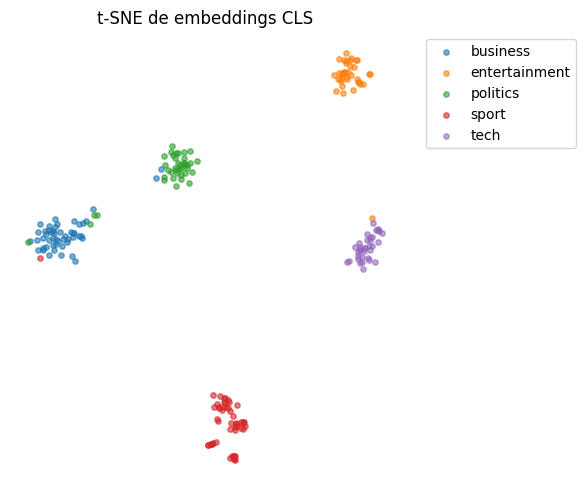

In [29]:
tsne_cls(model       = models["bert-base-uncased"] ,
          test_loader = loaders["bert-base-uncased"],
          class_names = le.classes_.tolist(),
          device      = DEVICE,
          save_path   = Path("tsne_cls_bert.npy"))

→ n_samples=213 | perplexity=21
Guardado en tsne_cls_roberta.npy


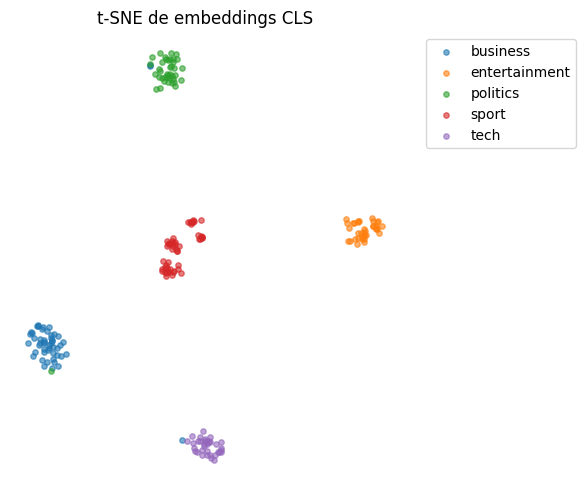

In [30]:
tsne_cls(model       = models["roberta-base"],
          test_loader = loaders["roberta-base"],
          class_names = le.classes_.tolist(),
          device      = DEVICE,
          save_path   = Path("tsne_cls_roberta.npy"))

Ambos modelos forman cinco *clusters* bien definidos para **business**, **entertainment**, **politics**, **sport** y **tech**. Con **BERT**, se aprecia cierta sobre-posición entre **business** y **politics**, y un punto aislado de **business** que sugiere mayor dispersión en esa clase. En el caso de **RoBERTa**, los *clusters* son más compactos y mejor separados; especialmente **politics** y **tech** muestran mayor cohesión interna. En ambos modelos, **sport** y **entertainment** quedan claramente aislados, pero **RoBERTa** ofrece representaciones más nítidas y consistentes.

***


# 6. Conclusión

El problema de clasificar artículos de la **BBC** en cinco categorías se abordó con modelos *transformer* —**`bert-base-uncased`** y **`roberta-base`**— entrenados con *fine-tuning* en GPU. Ambos convergieron  alrededor de las 2 épocas gracias a *early-stopping*, pero **RoBERTa** alcanzó las mejores métricas:

| Modelo | `Acc` | `F1_macro` | Tiempo total |
|--------|-------|------------|--------------|
| **BERT**   | 0.977 | 0.978 | ≈ 1.5 min |
| **RoBERTa**| **0.986** | **0.987** | ≈ 1.6 min |

* **Errores**: la clase **`business`** concentró la mayoría de FN/FP; RoBERTa redujo los errores totales de 10 a 6.  
* **Confusion matrices**: RoBERTa logró 100 % en **`sport`** y **`tech`**, mostrando separabilidad casi perfecta.  
* **t-SNE** de *embeddings* CLS: RoBERTa generó *clusters* más compactos y con menor solapamiento.  

Es posible que el pre-entrenamiento optimizado de RoBERTa traduce en representaciones contextuales más robustas y una ligera mejora general sin costo aadicional a nivel de cómputo. Se recomienda, para este problema en particular adoptar **RoBERTa** como modelo final; priorizar la revisión de datos de **`business`** (posible ambigüedad temática) y para futuros trabajos considerar técnicas de *data augmentation* para afinar esa categoría.

***


# 7. Referencias

[¹] **BERT: Pre-training of Deep Bidirectional Transformers for
Language Understanding  Google AI Language**  
Disponible en: [arxiv.org](https://arxiv.org/abs/1810.04805)

[²] **Documents Classification using BERT on BBC Dataset**  
Disponible en: [kaggle.com](https://www.kaggle.com/code/ouardasakram/documents-classification-using-bert-on-bbc-dataset)

[³] **Transfer Learning: Why We Freeze and Unfreeze Model Layers**  
Disponible en: [medium.com](https://medium.com/data-science-collective/transfer-learning-why-we-freeze-and-unfreeze-model-layers-0e0b8f9837ec)

[⁴] **Transformers: Optimization**  
Disponible en: [huggingface.co](https://huggingface.co/docs/transformers/en/main_classes/optimizer_schedules?utm_source=chatgpt.com)

[⁵] **Transformers: Auto Classes**  
Disponible en: [huggingface.co](https://huggingface.co/docs/transformers/en/model_doc/auto?utm_source=chatgpt.com)

[⁶] **RoBERTa: A Robustly Optimized BERT Pretraining Approach**  
Disponible en: [arxiv.org](https://arxiv.org/abs/1907.11692)

[⁷] **Bert-Classification-BBC-News**  
Disponible en: [github.com](https://github.com/bymi15/Bert-Classification-BBC-News/blob/main/bert_classification_bbc_news.ipynb)


